In [1]:
pip install yfinance

Note: you may need to restart the kernel to use updated packages.


In [2]:
# Importing necessary libraries
import yfinance as yf
import pandas as pd
import os
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt

In [3]:
# Check if the data file exists, if not download it
if os.path.exists("sp500.csv"):
    sp500 = pd.read_csv("sp500.csv", index_col=0)
else:
    sp500 = yf.Ticker("^GSPC")
    sp500 = sp500.history(period="max")
    sp500.to_csv("sp500.csv")

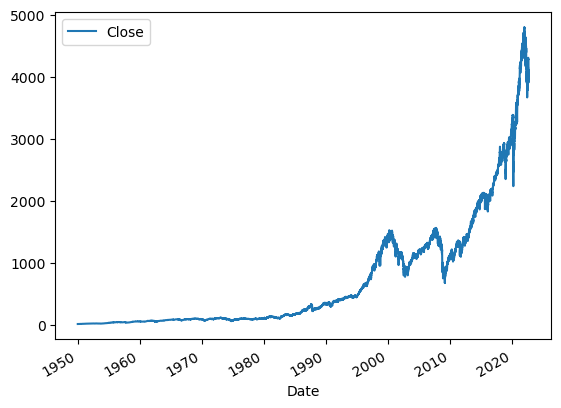

In [4]:
# Convert index to datetime and plot the closing prices
sp500.index = pd.to_datetime(sp500.index)
sp500.plot.line(y="Close", use_index=True)
plt.show()

In [5]:
# Data Cleaning and Preparation
sp500.drop(columns=["Dividends", "Stock Splits"], inplace=True)
sp500["Tomorrow"] = sp500["Close"].shift(-1)
sp500 = sp500.loc["1990-01-01":].copy()

In [6]:
# Drop rows with NaN values
sp500.dropna(inplace=True)

In [7]:
# Define the regression model
model = RandomForestRegressor(n_estimators=100, min_samples_split=100, random_state=1)

# Split data into train and test sets
train = sp500.iloc[:-100]
test = sp500.iloc[-100:]

In [8]:
# Define predictors
predictors = ["Close", "Volume", "Open", "High", "Low"]

# Train the model and predict
model.fit(train[predictors], train["Tomorrow"])
preds = model.predict(test[predictors])
preds = pd.Series(preds, index=test.index, name="Predictions")


In [9]:
# Evaluate the model
mse = mean_squared_error(test["Tomorrow"], preds)
print(f"Mean Squared Error: {mse}")

Mean Squared Error: 15555.895800446066


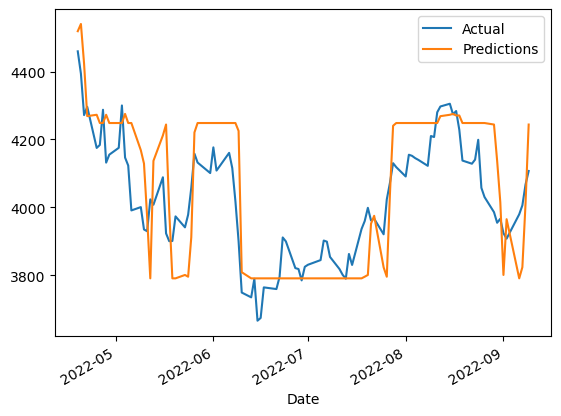

In [10]:
# Plot the actual vs predicted prices
combined = pd.concat([test["Tomorrow"], preds], axis=1)
combined.columns = ["Actual", "Predictions"]
combined.plot()
plt.show()


In [11]:
# Define the predict function for backtesting
def predict(train, test, predictors, model):
    train = train.dropna(subset=predictors + ["Tomorrow"])
    test = test.dropna(subset=predictors)
    model.fit(train[predictors], train["Tomorrow"])
    preds = model.predict(test[predictors])
    preds = pd.Series(preds, index=test.index, name="Predictions")
    combined = pd.concat([test["Tomorrow"], preds], axis=1)
    combined.columns = ["Actual", "Predictions"]
    return combined

In [12]:
# Define the backtesting function
def backtest(data, model, predictors, start=2500, step=250):
    all_predictions = []

    for i in range(start, data.shape[0], step):
        train = data.iloc[0:i].copy()
        test = data.iloc[i:(i+step)].copy()
        predictions = predict(train, test, predictors, model)
        all_predictions.append(predictions)
    
    return pd.concat(all_predictions)

In [13]:
# Perform backtesting
predictions = backtest(sp500, model, predictors)
print(predictions)

mse_backtest = mean_squared_error(predictions["Actual"], predictions["Predictions"])
print(f"Mean Squared Error (Backtest): {mse_backtest}")

                 Actual  Predictions
Date                                
1999-11-22  1404.640015  1364.909413
1999-11-23  1417.079956  1364.909413
1999-11-24  1416.619995  1364.909413
1999-11-26  1407.829956  1364.909413
1999-11-29  1388.910034  1364.909413
...                 ...          ...
2022-09-02  3908.189941  3917.496458
2022-09-06  3979.870117  3870.465094
2022-09-07  4006.179932  3870.465094
2022-09-08  4067.360107  3898.590713
2022-09-09  4107.279785  3998.157805

[5737 rows x 2 columns]
Mean Squared Error (Backtest): 41350.19894262254


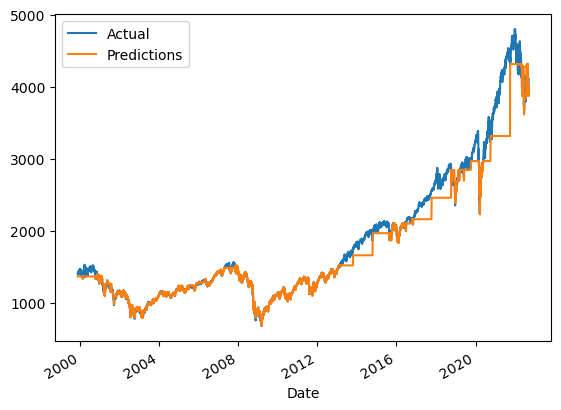

In [14]:
# Plot the backtest results
predictions.plot()
plt.show()